# Logistic Regression with uni, bi, and tri gram embeddings

## imports

In [1]:
import string
from os import listdir
from os.path import isfile, join
import nltk
from nltk import word_tokenize
from nltk.corpus import opinion_lexicon
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('opinion_lexicon')
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /Users/dylanedwards/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dylanedwards/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dylanedwards/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### setup puncuation and contractions to help clean text

In [2]:
punctuation = string.punctuation
positive_dict = set(opinion_lexicon.positive())
negative_dict = set(opinion_lexicon.negative())
positive_dict_stemmed = [PorterStemmer().stem(word) for word in positive_dict]
negative_dict_stemmed = [PorterStemmer().stem(word) for word in negative_dict]

contractions = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

### functions to help get data from txt files and to process and clean data

In [3]:
def get_file_key(fileName):
    # get the file num
    return int(fileName.split("_")[1].split(".")[0]) 
    
def get_files_from_dir(directory):
    filesInDir = [f for f in listdir(directory) if isfile(join(directory, f))]
    return sorted(filesInDir, key = get_file_key)   
        
def process_string_sentence(text):
        englishStopwords = stopwords.words("english")  # non-neccesary words
        text = text.lower()  # case folding
        # remove punctuation
        text = "".join([char for char in text if char not in punctuation])
        words = word_tokenize(text)
        removed = [word for word in words if word not in englishStopwords]
        stemmed = [PorterStemmer().stem(word) for word in removed]
        stemmed_sentence = " ".join(stemmed)
        return stemmed_sentence

def process_string(text):
        englishStopwords = stopwords.words("english")  # non-neccesary words
        text = text.lower()  # case folding
        # remove punctuation
        text = "".join([char for char in text if char not in punctuation])
        words = word_tokenize(text)
        removed = [word for word in words if word not in englishStopwords]
        return [", ".join(removed)]


def tokenize_files(files, dir):
        cleaned_positive_files = []
        for file in files:
            file_path = str.format("{}/{}", dir, file)
            with open(file_path) as f:
                raw_text = f.read()
                cleaned_positive_files.append(process_string(raw_text))
        return cleaned_positive_files

def is_word_positive(word):
        if word in positive_dict or word in positive_dict_stemmed:
            return True
        return False

def is_word_negative(word):
    if word in negative_dict or word in negative_dict_stemmed:
        return True
    return False



def get_word_occurrences(tokenized_files):
        word_occurrences = {}
        word_occurrences["positive"] = 0
        word_occurrences["negative"] = 0
        total_num_words = 0
        for file in tokenized_files:
            # calc number exclams
            # calc number pos/neg/words
            for word in file:
                if is_word_positive(word):
                    word_occurrences["positive"] += 1
                if is_word_negative(word):
                    word_occurrences["negative"] += 1
                if word not in word_occurrences:
                    word_occurrences[word] = 0
                word_occurrences[word] += 1
                total_num_words += 1
        return word_occurrences, total_num_words

def get_raw_text_from_files(files: list, dir: str) -> list:
    raw_text = []
    for file in files:
        file_path = str.format("{}/{}", dir, file)
        with open(file_path) as f:
            file_text_in_lines = f.read()
            raw_text.append(file_text_in_lines)
    return raw_text

def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings'''

    # Convert words to lower case
    text = text.lower()

    # Replace contractions with their longer forms
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)

    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text)
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)

    # remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    # Tokenize each word
    text =  nltk.WordPunctTokenizer().tokenize(text)

    return text


### gather and clean data 

In [4]:

df = pd.read_csv("./data/train.csv")


In [24]:
df[df["OpenStatus"] != "open"]

,PostId,PostCreationDate,OwnerUserId,OwnerCreationDate,ReputationAtPostCreation,OwnerUndeletedAnswerCountAtPostTime,Title,BodyMarkdown,Tag1,Tag2,Tag3,Tag4,Tag5,PostClosedDate,OpenStatus,Titles_Cleaned
7,23,08/01/2008 12:09:41,48,08/01/2008 13:25:15,1,0,Latest information on PHP upcoming releases,I'm trying to track the progress of PHP 5.3 an...,php,NaN,NaN,NaN,NaN,05/18/2012 11:12:42,not constructive,"[latest, information, php, upcoming, releases]"
30,126,08/01/2008 16:10:30,58,08/01/2008 13:56:33,11,1,How would you access Object properties from wi...,"What is the ""purist"" or ""correct"" way to acces...",oo,java,php,theory,NaN,05/08/2012 18:11:27,not constructive,"[would, access, object, properties, within, ob..."
31,129,08/01/2008 16:22:42,48,08/01/2008 13:25:15,11,1,How to export data from SQL Server to MySQL,I've been banging my head against SQL Server 2...,csv,ansi,sql,php,mssql,07/03/2012 14:30:16,off topic,"[export, data, sql, server, mysql]"
37,173,08/01/2008 18:33:08,83,08/01/2008 16:31:56,16,4,How do I version my MS SQL database in SVN?,I've been wanting to get my databases under ve...,subversion,svn,sql,mssql,versioncontrol,06/29/2012 15:08:28,not constructive,"[version, ms, sql, database, svn]"
41,177,08/01/2008 18:37:55,83,08/01/2008 16:31:56,16,4,How do I programmatically create a PDF in my ....,Please recommend a good library for programmat...,pdf,.net,NaN,NaN,NaN,04/25/2012 11:32:29,not constructive,"[programmatically, create, pdf, net, application]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3370359,11730687,07/30/2012 22:33:38,1564261,07/30/2012 22:28:15,1,0,PHP to DOT NET Conversion,I want to convert the following code to an ASP...,php,convert,dot,NaN,NaN,07/30/2012 22:48:15,too localized,"[php, dot, net, conversion]"
3370401,11730779,07/30/2012 22:42:22,710377,04/15/2011 18:38:06,65,6,How to create a custom theme in Microsoft Word...,"Background: Microsoft Office for Mac 2011, OS ...",ms-word,ms-office,NaN,NaN,NaN,07/31/2012 02:31:50,off topic,"[create, custom, theme, microsoft, word, mac, ..."
3370403,11730790,07/30/2012 22:44:28,1103893,12/17/2011 20:43:40,1,0,Calculate target or approximate number based o...,Please help me if someone can...\r\nProgram kn...,math,numbers,expression,target,NaN,07/31/2012 19:40:01,not constructive,"[calculate, target, approximate, number, based..."
3370477,11730983,07/30/2012 23:08:35,229072,12/10/2009 19:12:50,1719,36,Is berkeley packet filter ported to linux?,I am doing some research to figure out what di...,c,linux,linux-kernel,NaN,NaN,07/31/2012 02:26:23,off topic,"[berkeley, packet, filter, ported, linux]"


In [15]:
df2 = df.loc[1:1000]

In [23]:
df2[df2["OpenStatus"] != "open"]

,PostId,PostCreationDate,OwnerUserId,OwnerCreationDate,ReputationAtPostCreation,OwnerUndeletedAnswerCountAtPostTime,Title,BodyMarkdown,Tag1,Tag2,Tag3,Tag4,Tag5,PostClosedDate,OpenStatus,Titles_Cleaned
7,23,08/01/2008 12:09:41,48,08/01/2008 13:25:15,1,0,Latest information on PHP upcoming releases,I'm trying to track the progress of PHP 5.3 an...,php,NaN,NaN,NaN,NaN,05/18/2012 11:12:42,not constructive,"[latest, information, php, upcoming, releases]"
30,126,08/01/2008 16:10:30,58,08/01/2008 13:56:33,11,1,How would you access Object properties from wi...,"What is the ""purist"" or ""correct"" way to acces...",oo,java,php,theory,NaN,05/08/2012 18:11:27,not constructive,"[would, access, object, properties, within, ob..."
31,129,08/01/2008 16:22:42,48,08/01/2008 13:25:15,11,1,How to export data from SQL Server to MySQL,I've been banging my head against SQL Server 2...,csv,ansi,sql,php,mssql,07/03/2012 14:30:16,off topic,"[export, data, sql, server, mysql]"
37,173,08/01/2008 18:33:08,83,08/01/2008 16:31:56,16,4,How do I version my MS SQL database in SVN?,I've been wanting to get my databases under ve...,subversion,svn,sql,mssql,versioncontrol,06/29/2012 15:08:28,not constructive,"[version, ms, sql, database, svn]"
41,177,08/01/2008 18:37:55,83,08/01/2008 16:31:56,16,4,How do I programmatically create a PDF in my ....,Please recommend a good library for programmat...,pdf,.net,NaN,NaN,NaN,04/25/2012 11:32:29,not constructive,"[programmatically, create, pdf, net, application]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
868,7864,08/11/2008 15:30:30,751,08/08/2008 14:26:58,31,1,Why all the Active Record hate?,"As I learn more and more about OOP, and start ...",designpatterns,oop,activerecord,NaN,NaN,12/17/2011 01:17:11,not constructive,"[active, record, hate]"
913,8265,08/11/2008 21:53:58,1052,08/11/2008 21:48:53,1,0,Unit of Work Pattern in .Net,Does anyone have any concrete examples of a si...,.net,designpatterns,unitofwork,NaN,NaN,12/06/2011 03:02:09,not constructive,"[unit, work, pattern, net]"
937,8440,08/12/2008 03:53:53,493,08/06/2008 10:25:05,886,71,Visual Studio Optimizations,"Visual studio is a pretty awesome IDE, but som...",.net,visual-studio,NaN,NaN,NaN,09/12/2011 16:44:58,not constructive,"[visual, studio, optimizations]"
978,8756,08/12/2008 12:29:32,267,08/04/2008 10:11:06,1147,72,"iPhone web applications, templates, frameworks?",Does anyone have any good starting points for ...,iphone,web-applications,NaN,NaN,NaN,02/12/2012 19:52:58,not constructive,"[iphone, web, applications, templates, framewo..."


In [11]:
# neg_data = np.array(get_raw_text_from_files(get_files_from_dir("./data/neg"), "data/neg"))
# pos_data = np.array(get_raw_text_from_files(get_files_from_dir("./data/pos"), "data/pos"))
# allData = np.concatenate((neg_data, pos_data))
# # making labels for the data, the first
# neg_labels = np.fromiter([0 for i in range(len(neg_data))], int)  # create negative labels
# pos_labels = np.fromiter([1 for i in range(len(pos_data))], int)  # create positive labels
# allLabels = np.concatenate((neg_labels, pos_labels))

df['Titles_Cleaned'] = list(map(clean_text, df["Title"]))
df['Titles_Cleaned']


0                                      [decimal, vs, double]
1          [percentage, width, child, absolutely, positio...
2                               [tools, porting, j, code, c]
3                               [calculate, someone, age, c]
4                [retrieve, data, nsuserdefaults, tableview]
                                 ...                        
3370523                  [dividing, array, filter, function]
3370524                        [javascript, link, extractor]
3370525    [selenium, remote, webdriver, insane, memory, ...
3370526                     [searching, array, dictionaries]
3370527      [vb, net, array, integers, needs, instantiated]
Name: Titles_Cleaned, Length: 3370528, dtype: object

### function to run logistic regression model with the given bow converter and data

In [ ]:
def run_logisitc(allData, description,  bow_converter, _C=1.0,):
    kf = KFold(n_splits=5, shuffle=True)
    for trainingIndex, testingIndex in kf.split(allData):
        # get the train/test labels and data from split
        trainingData, testingData = allData[trainingIndex], allData[testingIndex]
        trainingLabels, testingLabels = allLabels[trainingIndex], allLabels[testingIndex]

        # convert the data to bow
        trainingData = bow_converter.fit_transform(trainingData)
        testingData = bow_converter.transform(testingData)

        # create the model
        model = LogisticRegression(C=1.0, max_iter=1000).fit(trainingData, trainingLabels)

        # get the model score
        score = model.score(testingData, testingLabels)
        print(description, " model score: ", score)

        # get label prediction
        labelPrediction = model.predict_proba(testingData)[:, 1]

        # use prediction to get metrics
        precision, recall, thresholds = precision_recall_curve(testingLabels, labelPrediction)
        average_precision = average_precision_score(testingLabels, labelPrediction)

        # plot curve
        disp = plot_precision_recall_curve(model, testingData, testingLabels)
        disp.ax_.set_title('2-class Precision-Recall curve: '
                        'AP={0:0.2f}'.format(average_precision))




trigram BOW  model score:  0.48


/Users/dylanedwards/Desktop/oxy-nlp/hw2/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


trigram BOW  model score:  0.5525


/Users/dylanedwards/Desktop/oxy-nlp/hw2/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


trigram BOW  model score:  0.555


/Users/dylanedwards/Desktop/oxy-nlp/hw2/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


trigram BOW  model score:  0.51


/Users/dylanedwards/Desktop/oxy-nlp/hw2/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


trigram BOW  model score:  0.5725


/Users/dylanedwards/Desktop/oxy-nlp/hw2/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


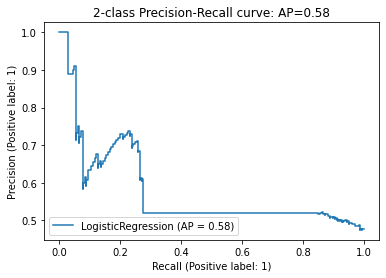

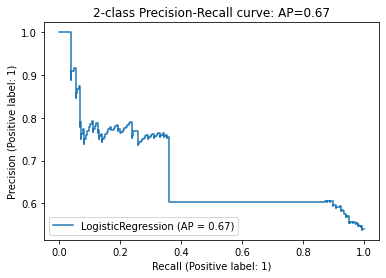

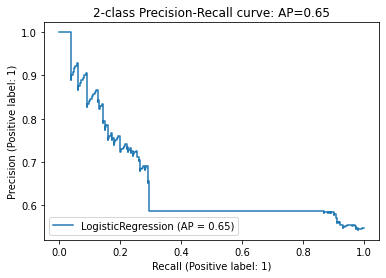

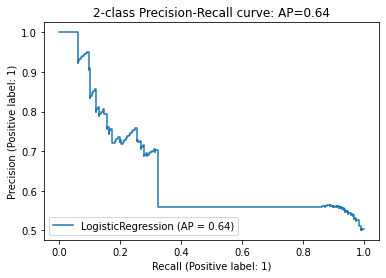

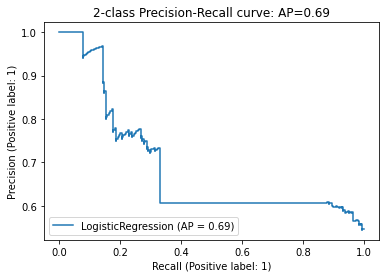

In [ ]:
bigram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[2,2], lowercase=False) 
run_logisitc(df['Text_Cleaned'], "bigram BOW", bigram_converter)

## Find Fake revies
#### reviews are classified as fake if they have a positive sentiment but the rating is low (1-2), or if the sentiment is negative but the rating is high (4-5)
#### reviews can also be classified as fake if they contain no english words or if they contain only stopwords and other words that would be cleaned
##### *I will use the logistic regression with unigram features to predict sentiment for fake reviews because it performed highest


In [ ]:
def getTrainedModel(allData,  bow_converter, _C=1.0,):
    kf = KFold(n_splits=5, shuffle=True)
    highestScore = 0 
    for trainingIndex, testingIndex in kf.split(allData):
        # get the train/test labels and data from split
        trainingData, testingData = allData[trainingIndex], allData[testingIndex]
        trainingLabels, testingLabels = allLabels[trainingIndex], allLabels[testingIndex]

        # convert the data to bow
        processedTrainingData = bow_converter.fit_transform(trainingData)
        processedTestingData = bow_converter.transform(testingData)

        # create the model
        model = LogisticRegression(C=1.0, max_iter=1000).fit(processedTrainingData, trainingLabels)

        # get the model score
        score = model.score(processedTestingData, testingLabels)
        print("model score: ", score)

        if score > highestScore:
            highestScore = score
            bestPerformingModel = model
            trainingDataToUse = trainingData

    print("model trained with score: ", highestScore)
    return bestPerformingModel, bow_converter, trainingDataToUse


In [ ]:
# get the trained model
unigram_bow_converter = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)
model, model_bow_converter, trainingDataToUse = getTrainedModel(df['Text_Cleaned'], unigram_bow_converter)

model score:  0.8
model score:  0.8025
model score:  0.8025
model score:  0.8025
model score:  0.8275
model trained with score:  0.8275


#### get the label prediction for 1000 negative and 1000 positive reviews concatenated

In [ ]:
# get label prediction 0 being negative and 1 being positive
model_bow_converter.fit_transform(trainingDataToUse)
allDataProcessed = model_bow_converter.transform(df['Text_Cleaned'])
labelPrediction = model.predict(allDataProcessed)
labelPrediction

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
#  these coorespond to 1000 negative + 1000 positive
print(df['Text_Cleaned'].shape)
labelPrediction.shape

def getRatings(dir):
    allRatings = []
    text = None
    with open(dir) as f:
        text = f.read()
        # get rating val and append to array
    allLines = text.split("\n")
    for line in allLines:
        rating = float(line.split(" ")[1])
        allRatings.append(rating)
    return allRatings

(2000,)


In [ ]:
negativeRatings = np.array(getRatings("./data/ratings/negative.txt"))
positiveRatings = np.array(getRatings("./data/ratings/positive.txt"))
allRatings = np.concatenate((negativeRatings, positiveRatings))

In [ ]:
def find_fake_reviews(labels, ratings):
    fakeReviewIndexs = []
    for index in range(len(labels)):
        if labels[index] == 0: # the review was marked negative by model
            if ratings[index] > 3: # if rating is greater than 3 its fake
                fakeReviewIndexs.append(index)
        else: # else the review was marked positive
            if ratings[index] < 3: # if ratings is less than 3 its fake
                fakeReviewIndexs.append(index)
    return fakeReviewIndexs

In [ ]:
fakeIndexs = find_fake_reviews(labelPrediction, allRatings)
print(fake)

all_raw_neg = np.array(get_raw_text_from_files(get_files_from_dir("./data/neg"), "./data/neg"))
all_raw_pos = np.array(get_raw_text_from_files(get_files_from_dir("./data/pos"), "./data/pos"))
all_raw_data = np.concatenate((all_raw_neg, all_raw_pos))

fake_review_content = {}
for index in fakeIndexs:
    fake_review_content[index] = all_raw_data[index]

fake_review_content

[45, 53, 64, 83, 141, 152, 161, 164, 214, 217, 284, 285, 296, 363, 408, 426, 453, 466, 483, 500, 501, 508, 522, 526, 598, 607, 614, 655, 703, 740, 749, 760, 766, 769, 773, 781, 782, 814, 819, 850, 880, 960, 964, 989, 1118, 1120, 1150, 1183, 1201, 1210, 1253, 1255, 1275, 1280, 1320, 1347, 1355, 1371, 1387, 1443, 1519, 1629, 1687, 1695, 1781, 1815, 1840, 1905, 1935, 1950, 1959]


{45: "I'm the consumer of SanDisk USB flash drives. I have used couple of sandisk flash drives (i.e. 512MB Mini, 256MB Mini) before I bought this product. \n\nPerformance wise this particular product is not doing good. It's taking long time to copy files from my computers. Even it's taking long time to delete files from this disk. So I returned to Amazon and looking for Mini products from SanDisk.\n\nI doubt all the Micro products which is having capacity more than 512MB. Now I'm planning to buy 512MB or 1GB SanDisk Mini USB flash drive.  \n\nBetter buy some good one than wasting your time on this product\n",
 53: "I like the features.  I'm satisfied with the sound.  The user interface could be more intuitive.\n\nHOWEVER, my overriding complaint is that the docking port (as many other reviewers have mentioned) is not reliable.  The connection is poorly constructed, so just walking by the table on which it sits is often enough to make it think the iPod isn't there any more.  If they cou